# Utility Library

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import requests
import os

def download_file(url, save_dir):
    # Extracting the filename from URL
    filename = url.split('/')[-1]
    file_path = os.path.join(save_dir, filename)

    # Making sure the save directory exists, if not, create it
    os.makedirs(save_dir, exist_ok=True)

    # Custom headers
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

    # Downloading the file and saving it
    response = requests.get(url, headers=headers, stream=True)
    if response.status_code == 200:
        with open(file_path, 'wb') as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)
        print(f"File downloaded: {file_path}")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")



class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            #print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor
            return out / 1.414

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels



class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)

        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()

        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim

        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]

        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)

def unorm(x):
    # unity norm. results in range of [0,1]
    # assume x (h,w,3)
    xmax = x.max((0,1))
    xmin = x.min((0,1))
    return(x - xmin)/(xmax - xmin)

def norm_all(store, n_t, n_s):
    # runs unity norm on all timesteps of all samples
    nstore = np.zeros_like(store)
    for t in range(n_t):
        for s in range(n_s):
            nstore[t,s] = unorm(store[t,s])
    return nstore

def norm_torch(x_all):
    # runs unity norm on all timesteps of all samples
    # input is (n_samples, 3,h,w), the torch image format
    x = x_all.cpu().numpy()
    xmax = x.max((2,3))
    xmin = x.min((2,3))
    xmax = np.expand_dims(xmax,(2,3))
    xmin = np.expand_dims(xmin,(2,3))
    nstore = (x - xmin)/(xmax - xmin)
    return torch.from_numpy(nstore)

def gen_tst_context(n_cfeat):
    """
    Generate test context vectors
    """
    vec = torch.tensor([
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0]]      # human, non-human, food, spell, side-facing
    )
    return len(vec), vec

def plot_grid(x,n_sample,n_rows,save_dir,w):
    # x:(n_sample, 3, h, w)
    ncols = n_sample//n_rows
    grid = make_grid(norm_torch(x), nrow=ncols)  # curiously, nrow is number of columns.. or number of items in the row.
    save_image(grid, save_dir + f"run_image_w{w}.png")
    print('saved image at ' + save_dir + f"run_image_w{w}.png")
    return grid

def plot_sample(x_gen_store,n_sample,nrows,save_dir, fn,  w, save=False):
    ncols = n_sample//nrows
    sx_gen_store = np.moveaxis(x_gen_store,2,4)                               # change to Numpy image format (h,w,channels) vs (channels,h,w)
    nsx_gen_store = norm_all(sx_gen_store, sx_gen_store.shape[0], n_sample)   # unity norm to put in range [0,1] for np.imshow

    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,figsize=(ncols,nrows))
    def animate_diff(i, store):
        print(f'gif animating frame {i} of {store.shape[0]}', end='\r')
        plots = []
        for row in range(nrows):
            for col in range(ncols):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow(store[i,(row*ncols)+col]))
        return plots
    ani = FuncAnimation(fig, animate_diff, fargs=[nsx_gen_store],  interval=200, blit=False, repeat=True, frames=nsx_gen_store.shape[0])
    plt.close()
    if save:
        ani.save(save_dir + f"{fn}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
        print('saved gif at ' + save_dir + f"{fn}_w{w}.gif")
    return ani


class CustomDataset(Dataset):
    def __init__(self, sfilename, lfilename, transform, null_context=False):
        self.sprites = np.load(sfilename)
        self.slabels = np.load(lfilename)
        print(f"sprite shape: {self.sprites.shape}")
        print(f"labels shape: {self.slabels.shape}")
        self.transform = transform
        self.null_context = null_context
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape

    # Return the number of images in the dataset
    def __len__(self):
        return len(self.sprites)

    # Get the image and label at a given index
    def __getitem__(self, idx):
        # Return the image and label as a tuple
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return (image, label)

    def getshapes(self):
        # return shapes of data and labels
        return self.sprites_shape, self.slabel_shape

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]

])

# Lab 2, Training

In [2]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML

# Setting Things Up

In [3]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(ContextUnet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4, so 28,24,20,16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]

         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]

        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out


In [4]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = './weights/'
download_file('https://geominetool.com/pucp/model_0.pth', save_dir)  # preload model steps
download_file('https://geominetool.com/pucp/model_4.pth', save_dir)  # preload model steps
download_file('https://geominetool.com/pucp/model_8.pth', save_dir)  # preload model steps
download_file('https://geominetool.com/pucp/model_31.pth', save_dir)  # preload model steps

# training hyperparameters
batch_size = 100
n_epoch = 32
lrate=1e-3

File downloaded: ./weights/model_0.pth
File downloaded: ./weights/model_4.pth
File downloaded: ./weights/model_8.pth
File downloaded: ./weights/model_31.pth


In [5]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1

In [6]:
# construct model
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

# Training

In [7]:
save_directory = './'
download_file('https://geominetool.com/pucp/sprites_1788_16x16.npy', save_directory)
download_file('https://geominetool.com/pucp/sprite_labels_nc_1788_16x16.npy', save_directory)

File downloaded: ./sprites_1788_16x16.npy
File downloaded: ./sprite_labels_nc_1788_16x16.npy


In [8]:
# load dataset and construct optimizer
dataset = CustomDataset("./sprites_1788_16x16.npy", "./sprite_labels_nc_1788_16x16.npy", transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


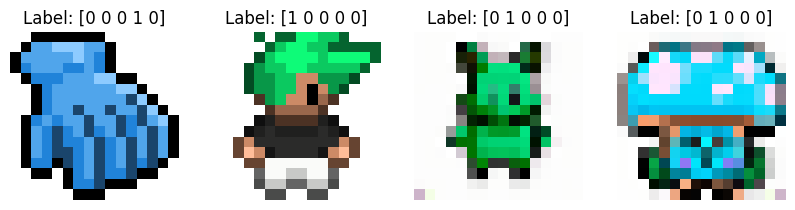

In [9]:
import matplotlib.pyplot as plt

def show_images(images, labels, num_images=4):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2.5))
    axes = axes.flatten()
    for img, lbl, ax in zip(images, labels, axes):
        img = img.numpy().transpose((1, 2, 0))
        img = img * 0.5 + 0.5  # unnormalize
        ax.imshow(img, cmap="gray")
        ax.axis('off')

        # Check the number of elements in the label tensor
        if lbl.nelement() == 1:
            ax.set_title(f"Label: {lbl.item()}")
        else:
            ax.set_title(f"Label: {lbl.numpy()}")  # Adjust this based on your label format

    plt.show()

# Display some images from the dataset
for images, labels in dataloader:
    show_images(images, labels)
    break  # only show the first batch


In [10]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

#### This code will take hours to run on a CPU. We recommend you skip this step here and check the intermediate results below.
If you decide to try it, you could download to your own machine. Be sure to change the cell type.
Note, the CPU run time in the course is limited so you will not be able to fully train the network using the class platform.

In [11]:
# training without context code

# set into train mode
nn_model.train()

for ep in range(n_epoch):
    print(f'epoch {ep}')

    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

    pbar = tqdm(dataloader, mininterval=2 )
    for x, _ in pbar:   # x: images
        optim.zero_grad()
        x = x.to(device)

        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device)
        x_pert = perturb_input(x, t, noise)

        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps)

        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()

        optim.step()

    # save model periodically
    if ep%4==0 or ep == int(n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(nn_model.state_dict(), save_dir + f"model_{ep}.pth")
        print('saved model at ' + save_dir + f"model_{ep}.pth")

epoch 0


100%|██████████| 894/894 [00:37<00:00, 23.68it/s]


saved model at ./weights/model_0.pth
epoch 1


100%|██████████| 894/894 [00:30<00:00, 29.41it/s]


epoch 2


100%|██████████| 894/894 [00:29<00:00, 30.16it/s]


epoch 3


100%|██████████| 894/894 [00:29<00:00, 29.91it/s]


epoch 4


100%|██████████| 894/894 [00:29<00:00, 30.32it/s]


saved model at ./weights/model_4.pth
epoch 5


100%|██████████| 894/894 [00:29<00:00, 30.50it/s]


epoch 6


100%|██████████| 894/894 [00:29<00:00, 29.80it/s]


epoch 7


100%|██████████| 894/894 [00:29<00:00, 30.41it/s]


epoch 8


100%|██████████| 894/894 [00:29<00:00, 30.42it/s]


saved model at ./weights/model_8.pth
epoch 9


100%|██████████| 894/894 [00:30<00:00, 29.76it/s]


epoch 10


100%|██████████| 894/894 [00:29<00:00, 30.46it/s]


epoch 11


100%|██████████| 894/894 [00:29<00:00, 30.47it/s]


epoch 12


100%|██████████| 894/894 [00:29<00:00, 29.99it/s]


saved model at ./weights/model_12.pth
epoch 13


100%|██████████| 894/894 [00:29<00:00, 30.33it/s]


epoch 14


100%|██████████| 894/894 [00:29<00:00, 30.42it/s]


epoch 15


100%|██████████| 894/894 [00:29<00:00, 30.23it/s]


epoch 16


100%|██████████| 894/894 [00:29<00:00, 30.01it/s]


saved model at ./weights/model_16.pth
epoch 17


100%|██████████| 894/894 [00:29<00:00, 30.32it/s]


epoch 18


100%|██████████| 894/894 [00:29<00:00, 30.43it/s]


epoch 19


100%|██████████| 894/894 [00:29<00:00, 29.89it/s]


epoch 20


100%|██████████| 894/894 [00:29<00:00, 30.26it/s]


saved model at ./weights/model_20.pth
epoch 21


100%|██████████| 894/894 [00:29<00:00, 30.56it/s]


epoch 22


100%|██████████| 894/894 [00:29<00:00, 29.91it/s]


epoch 23


100%|██████████| 894/894 [00:29<00:00, 30.49it/s]


epoch 24


100%|██████████| 894/894 [00:29<00:00, 30.57it/s]


saved model at ./weights/model_24.pth
epoch 25


100%|██████████| 894/894 [00:29<00:00, 29.86it/s]


epoch 26


100%|██████████| 894/894 [00:29<00:00, 30.54it/s]


epoch 27


100%|██████████| 894/894 [00:29<00:00, 30.62it/s]


epoch 28


100%|██████████| 894/894 [00:29<00:00, 29.81it/s]


saved model at ./weights/model_28.pth
epoch 29


100%|██████████| 894/894 [00:29<00:00, 30.44it/s]


epoch 30


100%|██████████| 894/894 [00:29<00:00, 30.52it/s]


epoch 31


100%|██████████| 894/894 [00:29<00:00, 30.13it/s]

saved model at ./weights/model_31.pth


# Sampling

In [22]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [23]:
# sample using standard algorithm
@torch.no_grad()
def sample_ddpm(n_sample, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t)    # predict noise e_(x_t,t)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate ==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

#### View Epoch 0

In [24]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_0.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


<ipython-input-24-6dc9ab88779e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model.load_state_dict(torch.load(f"{save_dir}/model_0.pth", map_location=device))


In [25]:
# visualize samples
plt.clf()
samples, intermediate_ddpm = sample_ddpm(8)
animation_ddpm = plot_sample(intermediate_ddpm,8,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm.to_jshtml())

<Figure size 640x480 with 0 Axes>

#### View Epoch 4

In [26]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_4.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


<ipython-input-26-c8d9247ada89>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model.load_state_dict(torch.load(f"{save_dir}/model_4.pth", map_location=device))


In [27]:
# visualize samples
plt.clf()
samples, intermediate_ddpm = sample_ddpm(8)
animation_ddpm = plot_sample(intermediate_ddpm,8,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm.to_jshtml())

<Figure size 640x480 with 0 Axes>

#### View Epoch 8

In [28]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_8.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


<ipython-input-28-0b5379b954bb>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model.load_state_dict(torch.load(f"{save_dir}/model_8.pth", map_location=device))


In [29]:
# visualize samples
plt.clf()
samples, intermediate_ddpm = sample_ddpm(8)
animation_ddpm = plot_sample(intermediate_ddpm,8,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm.to_jshtml())

<Figure size 640x480 with 0 Axes>

#### View Epoch 31

In [30]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_31.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


<ipython-input-30-0a05d04f0cce>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model.load_state_dict(torch.load(f"{save_dir}/model_31.pth", map_location=device))


In [31]:
# visualize samples
plt.clf()
samples, intermediate_ddpm = sample_ddpm(8)
animation_ddpm = plot_sample(intermediate_ddpm,8,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm.to_jshtml())

<Figure size 640x480 with 0 Axes>